In [179]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from rembg import remove
from tqdm import tqdm
from PIL import Image
from collections import deque

In [170]:
def displaySample(path, imgCnt=10):
    fileInPath = os.listdir(path)

    # Create a figure to display the images
    fig = plt.figure(figsize=(20, 20))

    # Display the images
    for i in range(imgCnt):
        img = mpimg.imread(path + random.choice(fileInPath))
        ax = fig.add_subplot(1, imgCnt, i + 1)
        ax.imshow(img)
        ax.axis('off')

    plt.show()

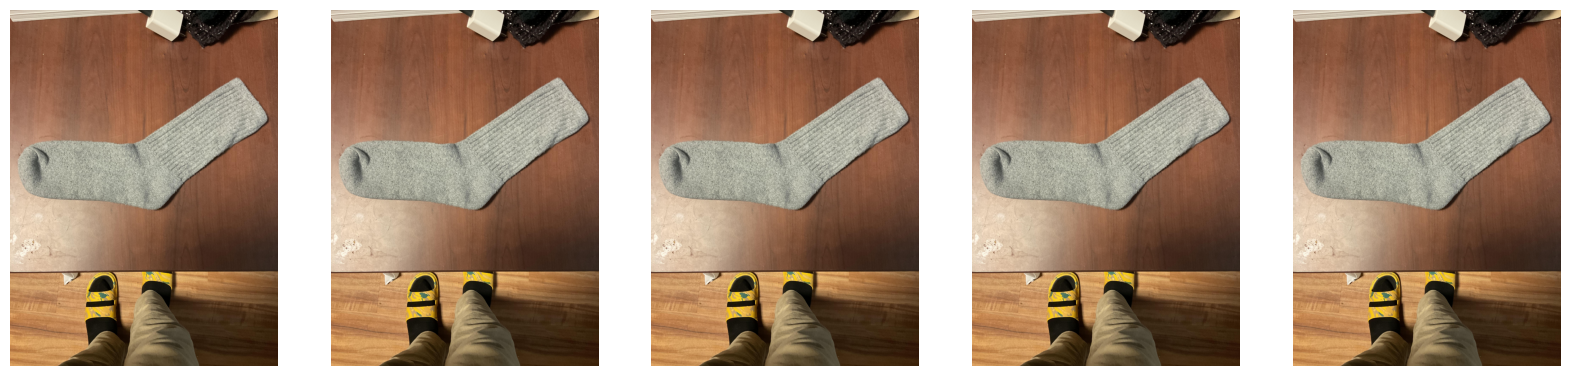

In [171]:
displaySample("./JPG/", 5)

## 1. Preprocessing

In [201]:
# Create folders for the images
if not os.path.exists("./JPG/"):
    os.makedirs("./JPG/")

if not os.path.exists("./Resized/"):
    os.makedirs("./Resized/")

if not os.path.exists("./RemBg/"):
    os.makedirs("./RemBg/")
    
if not os.path.exists("./Centered/"):
    os.makedirs("./Centered/")

### 1.1. Resizing Images

In [205]:
def resize(path, output, size=(512, 512)):
    fileInPath = os.listdir(path)

    for file in tqdm(fileInPath):
        outputPath = output + file
        if not os.path.exists(outputPath):
          img = cv2.imread(path + file)
          img = cv2.resize(img, size)
          cv2.imwrite(outputPath, img)

In [206]:
resize("./JPG/", "./Resized/")

100%|██████████| 49/49 [00:14<00:00,  3.38it/s]


### 1.1. Removing Background and saving the images

In [207]:
def removeBg(path): 
  # TODO: Force the user to fit the image into sock shaped thing. And only start from that square.

  files = os.listdir(path)

  for file in tqdm(files):
    if file.endswith(".jpg"):
      input_path = os.path.join(path, file)
      output_path = os.path.join("./RemBg/", file)
    
      if not os.path.exists(output_path):
        # tqdm.write("Removing background from image: " + file)

        # Saving the image with removed background
        input_array = np.array(Image.open(input_path))
        result = remove(input_array)
        img = Image.fromarray(result).convert("RGB")
        img.save(output_path)
        
        # Removing the original image
        # os.remove(input_path)
      
      

In [209]:
removeBg("./Resized/")

100%|██████████| 49/49 [02:43<00:00,  3.34s/it]


### 1.2. Centering the images

#### 1.2.1.  By removing the black rows / cols from all 4 sides

In [210]:
def isArrayBlack(arr):
  THRESHOLD = 0.03 # If 95% of the array is black, then it is black
  cnt = np.count_nonzero(np.count_nonzero(arr != [0, 0, 0], axis=1))
  # print(cnt, len(arr) * THRESHOLD, len(arr))
  return cnt < len(arr) * THRESHOLD

def centerImage(imgPath, newPath):
  img = cv2.imread(imgPath)

  np_img = np.array(img)

  # Remove rows / cols with only black pixels

  top = 0
  for i in range(np_img.shape[0]):
    row = np_img[i]
    if not isArrayBlack(row):
      top = i
      break
  
  bottom = len(np_img)
  for i in range(np_img.shape[0] - 1, 0, -1):
    row = np_img[i]
    if not isArrayBlack(row):
      bottom = i
      break
  
  left = 0
  for i in range(np_img.shape[1]):
    col = np_img[:, i]
    if not isArrayBlack(col):
      left = i
      break
  
  right = len(np_img[1])
  for i in range(np_img.shape[1] - 1, 0, -1):
    col = np_img[:, i]
    if not isArrayBlack(col):
      right = i
      break

  # Crop the image
  np_img = np_img[top:bottom, left:right]

  # Save the image
  cv2.imwrite(newPath, np_img)

  # Remove the original image
  # os.remove(imgPath)

#### 1.2.2. By assuming the center of the image is part of the image and BFS out farther till we find a black pixel
- Issue with this could be time complexity

In [229]:
def centerImage(imgPath, newPath):
  img = cv2.imread(imgPath)
  img = cv2.resize(img, (512, 512))
  np_img = np.array(img)

  center_img = np.array([np_img.shape[0] // 2, np_img.shape[1] // 2])

  pixel_queue = deque([center_img])
  visited = {}
  
  top = float("inf")
  bottom = -1
  left = float("inf")
  right = -1

  firstTime = True

  while pixel_queue:
    pixel = pixel_queue.popleft()
    if visited.get(str(pixel)) == True:
      continue

    visited[str(pixel)] = True

    if firstTime or np_img[pixel[0]][pixel[1]][0] != 0 or np_img[pixel[0]][pixel[1]][1] != 0 or np_img[pixel[0]][pixel[1]][2] != 0:
      firstTime = False
      
      # Findng top, bottom, left, right coordinates
      top  = min(top, pixel[0])
      bottom = max(bottom, pixel[0])
      left = min(left, pixel[1])
      right = max(right, pixel[1])

      # Going to neighboring pixels (up, down, left, right)
      # TODO: For satefy, you could also go to the diagonally neighboring pixels
      pixel_queue.append([pixel[0] - 1, pixel[1]])
      pixel_queue.append([pixel[0] + 1, pixel[1]])
      pixel_queue.append([pixel[0], pixel[1] - 1])
      pixel_queue.append([pixel[0], pixel[1] + 1])

  try:
    # Crop the image
    np_img = np_img[top:bottom, left:right]

    # Save the image
    cv2.imwrite(newPath, np_img)
  except Exception as e:
    print(f"Image {imgPath} is not centered or something went wrong")
    print(e)

  # Remove the original image
  # os.remove(imgPath)



In [230]:
def centerImages(path, newPath):
  files = os.listdir(path)

  for file in tqdm(files):
    newFilePath = os.path.join(newPath, file)

    if not os.path.exists(newFilePath):
      centerImage(os.path.join(path, file), newFilePath)

In [231]:
centerImages("./RemBg/", "./Centered/")

  0%|          | 0/49 [00:00<?, ?it/s]

Centering image: ./RemBg/IMG_0555.jpg


  6%|▌         | 3/49 [00:02<00:31,  1.45it/s]

(206, 470, 3)
Centering image: ./RemBg/IMG_0556.jpg


  8%|▊         | 4/49 [00:03<00:37,  1.22it/s]

(196, 488, 3)
Centering image: ./RemBg/IMG_0557.jpg


 10%|█         | 5/49 [00:04<00:43,  1.01it/s]

(211, 448, 3)
Centering image: ./RemBg/IMG_0558.jpg


 12%|█▏        | 6/49 [00:05<00:42,  1.02it/s]

(225, 439, 3)
Centering image: ./RemBg/IMG_0564.jpg


 14%|█▍        | 7/49 [00:06<00:39,  1.05it/s]

(199, 337, 3)
Centering image: ./RemBg/IMG_0565.jpg


 16%|█▋        | 8/49 [00:07<00:40,  1.01it/s]

(257, 459, 3)
Centering image: ./RemBg/IMG_0566.jpg


 18%|█▊        | 9/49 [00:07<00:32,  1.22it/s]

(97, 256, 3)
Centering image: ./RemBg/IMG_0567.jpg


 20%|██        | 10/49 [00:08<00:27,  1.41it/s]

(103, 241, 3)
Centering image: ./RemBg/IMG_0568.jpg


 22%|██▏       | 11/49 [00:09<00:33,  1.15it/s]

(209, 464, 3)
Centering image: ./RemBg/IMG_0569.jpg


 24%|██▍       | 12/49 [00:09<00:26,  1.39it/s]

(88, 222, 3)
Centering image: ./RemBg/IMG_0570.jpg


 27%|██▋       | 13/49 [00:10<00:25,  1.39it/s]

(129, 320, 3)
Centering image: ./RemBg/IMG_0571.jpg


 29%|██▊       | 14/49 [00:11<00:26,  1.31it/s]

(129, 303, 3)
Centering image: ./RemBg/IMG_0572.jpg


 31%|███       | 15/49 [00:12<00:27,  1.23it/s]

(129, 368, 3)
Centering image: ./RemBg/IMG_0573.jpg


 33%|███▎      | 16/49 [00:13<00:28,  1.14it/s]

(144, 360, 3)
Centering image: ./RemBg/IMG_0574.jpg


 35%|███▍      | 17/49 [00:14<00:28,  1.11it/s]

(145, 306, 3)
Centering image: ./RemBg/IMG_0575.jpg


 37%|███▋      | 18/49 [00:15<00:26,  1.18it/s]

(128, 304, 3)
Centering image: ./RemBg/IMG_0577.jpg


 39%|███▉      | 19/49 [00:16<00:30,  1.03s/it]

(141, 419, 3)
Centering image: ./RemBg/IMG_0578.jpg


 41%|████      | 20/49 [00:17<00:30,  1.04s/it]

(145, 354, 3)
Centering image: ./RemBg/IMG_0579.jpg


 43%|████▎     | 21/49 [00:19<00:35,  1.26s/it]

(156, 385, 3)
Centering image: ./RemBg/IMG_0580.jpg


 45%|████▍     | 22/49 [00:20<00:35,  1.31s/it]

(144, 400, 3)
Centering image: ./RemBg/IMG_0581.jpg


 47%|████▋     | 23/49 [00:22<00:34,  1.34s/it]

(229, 464, 3)
Centering image: ./RemBg/IMG_0583.jpg


 49%|████▉     | 24/49 [00:24<00:37,  1.49s/it]

(247, 449, 3)
Centering image: ./RemBg/IMG_0584.jpg


 51%|█████     | 25/49 [00:24<00:30,  1.28s/it]

(129, 321, 3)
Centering image: ./RemBg/IMG_0585.jpg


 53%|█████▎    | 26/49 [00:25<00:27,  1.18s/it]

(138, 328, 3)
Centering image: ./RemBg/IMG_0586.jpg


 55%|█████▌    | 27/49 [00:27<00:28,  1.29s/it]

(209, 417, 3)
Centering image: ./RemBg/IMG_0587.jpg


 57%|█████▋    | 28/49 [00:28<00:26,  1.26s/it]

(145, 379, 3)
Centering image: ./RemBg/IMG_0588.jpg


 59%|█████▉    | 29/49 [00:29<00:24,  1.25s/it]

(161, 387, 3)
Centering image: ./RemBg/IMG_0589.jpg


 61%|██████    | 30/49 [00:31<00:24,  1.27s/it]

(241, 433, 3)
Centering image: ./RemBg/IMG_0590.jpg
(0, 0, 3)
Image ./RemBg/IMG_0590.jpg is not centered or something went wrong
OpenCV(4.8.1) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

Centering image: ./RemBg/IMG_0591.jpg


 65%|██████▌   | 32/49 [00:32<00:16,  1.04it/s]

(161, 399, 3)
Centering image: ./RemBg/IMG_0592.jpg


 67%|██████▋   | 33/49 [00:33<00:15,  1.01it/s]

(177, 382, 3)
Centering image: ./RemBg/IMG_0593.jpg


 69%|██████▉   | 34/49 [00:34<00:14,  1.04it/s]

(145, 337, 3)
Centering image: ./RemBg/IMG_0594.jpg


 71%|███████▏  | 35/49 [00:35<00:14,  1.02s/it]

(241, 448, 3)
Centering image: ./RemBg/IMG_0595.jpg


 73%|███████▎  | 36/49 [00:36<00:14,  1.14s/it]

(161, 438, 3)
Centering image: ./RemBg/IMG_0596.jpg
(0, 0, 3)
Image ./RemBg/IMG_0596.jpg is not centered or something went wrong
OpenCV(4.8.1) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

Centering image: ./RemBg/IMG_0597.jpg


 78%|███████▊  | 38/49 [00:38<00:11,  1.01s/it]

(133, 401, 3)
Centering image: ./RemBg/IMG_0598.jpg


 80%|███████▉  | 39/49 [00:39<00:09,  1.01it/s]

(131, 337, 3)
Centering image: ./RemBg/IMG_0599.jpg


 82%|████████▏ | 40/49 [00:40<00:09,  1.06s/it]

(209, 416, 3)
Centering image: ./RemBg/IMG_0600.jpg


 84%|████████▎ | 41/49 [00:41<00:08,  1.07s/it]

(209, 417, 3)
Centering image: ./RemBg/IMG_0601.jpg


 86%|████████▌ | 42/49 [00:43<00:07,  1.10s/it]

(168, 398, 3)
Centering image: ./RemBg/IMG_0602.jpg


 88%|████████▊ | 43/49 [00:44<00:06,  1.15s/it]

(262, 427, 3)
Centering image: ./RemBg/IMG_0603.jpg


 90%|████████▉ | 44/49 [00:45<00:05,  1.08s/it]

(152, 353, 3)
Centering image: ./RemBg/IMG_0604.jpg


 92%|█████████▏| 45/49 [00:46<00:04,  1.18s/it]

(177, 433, 3)
Centering image: ./RemBg/IMG_0605.jpg


 94%|█████████▍| 46/49 [00:48<00:03,  1.21s/it]

(264, 469, 3)
Centering image: ./RemBg/IMG_0606.jpg


 96%|█████████▌| 47/49 [00:49<00:02,  1.20s/it]

(214, 454, 3)
Centering image: ./RemBg/IMG_0607.jpg


 98%|█████████▊| 48/49 [00:50<00:01,  1.13s/it]

(204, 416, 3)
Centering image: ./RemBg/IMG_0608.jpg


100%|██████████| 49/49 [00:50<00:00,  1.04s/it]

(122, 290, 3)
